# Desarrollo de una aplicación para la construcción de mapas de conocimiento generados por un tema de investigación

### Trabajo final de maestría
#### Realizado por: Jairo Castrellón 

## Resumen

El uso de herramientas bibliométricas para el análisis de las tendencias en investigación se hace cada vez más necesario en el mundo de la producción académica debido a la velocidad en la que se está generando nuevo conocimiento y la gran capacidad de los medios digitales para poner esta información a disposición de los interesados en las diferentes bases de datos, en este caso, de redes bibliográficas. En particular, los mapas de conocimiento se han convertido en guías importantes para los investigadores, en la medida que les permite tener un amplio panorama del flujo que presenta su tema de interes, de tal manera que visualicen las áreas y subáreas mas relevantes en su investigación. Éste trabajo pretende ofrecer una alternativa a las herramientas que ya existen mediante un software de aplicación, haciendo un análisis más exhaustivo en la generación de palabras y conceptos clave que se puedan inferir de la información básica de un texto investigativo, a parte de los que el autor emite como palabras clave. 

Esta aplicación aquí desarrollada, se trabajará y evaluará tomando como ejemplo un tema de investigación en específico y ralizando su respectivo análisis. Se pretende hacer explicito la descripción de la obtención de los datos con los cuales se están trabajando, asi como las metodologías usadas para el preprocesamiento de los mismos, generación de palabras clave (keywords) y construcción de los respectivos mapas de conocimiento.

## 0. Instalación y carga de librerias

En la siguiente sección se hará la instalación y el cargue de librerias utilizadas en todo este trabajo. En el transcurso del documento y en la medida en la que se vaya haciendo uso especial de estas, se ira describiendo sus funcionalidades y el motivo por el cual se utilizan.

In [ ]:
#!pip install rake-nltk
#!pip install nltk
#!pip install multiprocessing
#!pip3 install keyphrase-vectorizers
#!pip3 install keybert
#!pip3 install spacy

In [1]:
import pandas as pd
import numpy as np
from rake_nltk import Rake
import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

# Descargar recursos de NLTK necesarios si aún no los tienes
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')

## 1. Selección conjunto de datos

Se ha seleccionado como conjunto de datos para el desarrollo de este trabajo el DBLP. Este es un conjunto de datos que forma una red de citas, compuesto por información extraída de diversas fuentes, como DBLP, ACM y MAG. Contiene datos útiles para diversas aplicaciones, como agrupamiento con información de red, análisis de influencia en la red de citas y modelado de temas.

Se tomó una muestra de este conjunto de datos que contiene un millón de registros relacionados a la información de los artículos, los cuales, tienen como temática principal la ciencia de datos. En la siguiente tabla se muestra la descripción de las variables que contiene el conjunto de datos:

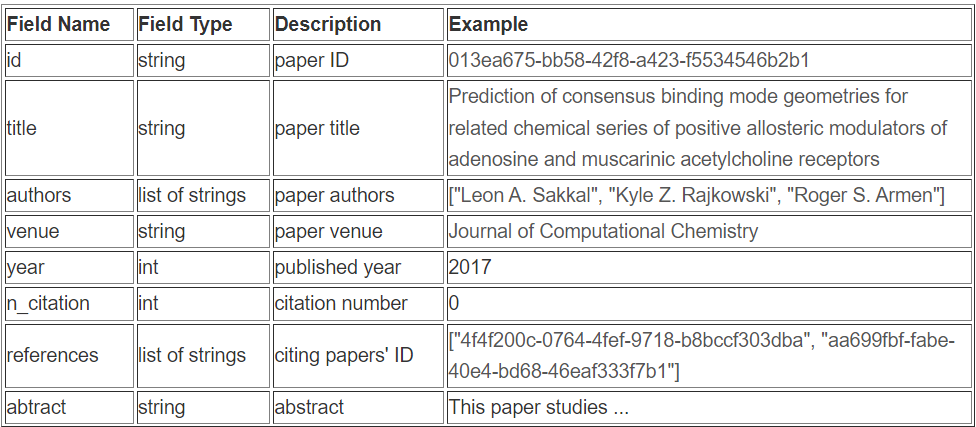

In [2]:
data=pd.read_csv("archive/dblp-v10.csv")

In [3]:
data.shape

(1000000, 8)

A continuación se visualiza información general de las variables, donde se observa que existen registros que no tiene información de resumen (abstract). Estos registros serán eliminados de nuestro conjunto de datos de desarrollo, pues es primordial contar con esta información para la generación de las palabras clave.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   abstract    827533 non-null   object
 1   authors     999998 non-null   object
 2   n_citation  1000000 non-null  int64 
 3   references  875583 non-null   object
 4   title       1000000 non-null  object
 5   venue       822245 non-null   object
 6   year        1000000 non-null  int64 
 7   id          1000000 non-null  object
dtypes: int64(2), object(6)
memory usage: 61.0+ MB


## 2. Preprocesamiento de los datos

Como se mencionó anteriormente, se omitiran los registros para los cuales no se tenga información del resumen de los artículos (abstract). Inicialmente, para el análisis que se quiere realizar, es necesario realizar un proceso de vectorización, del cuál se obtendrá el modelo de espacio vectorial (VSM), que es un modelo algebraico popular y utilizado para representar documentos de texto como vectores de identificadores. Aquí, cada documento se puede representar como vectores multidimensionales de palabras extraídas de ese documento en el espacio euclidiano. 

Nótese que para obtener este espacio de vectores, es necesario previamente eliminar información de los textos con los que se trabajará, para que no se genere ruido, por ejemplo, los denominados stopwords, que son palabras sin significado como artículos, pronombres, preposiciones, por ejemplo, “the”, “of ”, “is”, etc., en inglés, que tienen alta frecuencia, pero aportan poco al estudio que se quiere.

Otro proceso adecuado para este la vectorización, es conocido en inglés como tokenization, que consiste en obtener la raíz de las palabras, de tal manera que dos palabras que representen el mismo concepto, pero esten escritas en diferente forma gramátical, puedan verse como el mismo elemento, por ejemplo, a las palabras “written”, “writted”, “writing” y “write”, se les puede asociar la palabra raíz “writ”, de tal manera que se entienda que todas hacen referencia al verbo “write”.

In [5]:
data=data[~data['title'].isnull()]
data=data[~data['abstract'].isnull()].reset_index(drop=True)

In [6]:
# Funcion de procesamiento del texto

stop_words = set(stopwords.words('english'))
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def process_text(text):
    # Tokenization
    tokens = text.split()
    
    # Remove punctuation and lower casing
    tokens = [word.lower() for word in tokens if word.isalnum()]
    
    # Stop words removal
    filtered_tokens = [word for word in tokens if word not in stop_words]
    
    # Stemming
    stemmed_tokens = [ps.stem(word) for word in filtered_tokens]
    
    # Lemmatization
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in stemmed_tokens]
    
    # Convert tokens back to a single string
    processed_text = ' '.join(lemmatized_tokens)
    
    return processed_text

In [7]:
# Aplicar la función a las columnas
data["title_transformed"] = data["title"].apply(process_text)
data["abstract_transformed"] = data["abstract"].apply(process_text)

In [8]:
data["full_text"]=data["title_transformed"]+" ; "+data["abstract_transformed"]

## 3. Generación de palabras clave

Para el proceso de generación de palabras clave se van a considerar las siguientes metodologías:

### a. Frecuencia de Palabras (TF-IDF):

*  ***Cómo funciona:*** Calcula la frecuencia de cada palabra en el texto y asigna un peso basado en la frecuencia en el documento y en la colección total de documentos. Palabras con frecuencia alta en el documento pero baja en la colección obtienen un peso más alto.
*  ***Ventajas:*** Simple y eficiente.
*  ***Limitaciones:*** No considera la relación semántica entre palabras.

### b. Extracción de Frases Clave (Keyphrase Extraction):

*  ***Cómo funciona:*** Identifica frases que son representativas del contenido del texto. Puede basarse en la frecuencia de palabras, relaciones gramaticales y co-ocurrencias.
*  ***Ventajas:*** Puede capturar la esencia del contenido.
*  ***Limitaciones:*** No siempre produce palabras clave únicas y puede depender de la calidad del texto.

### c. Enfoques de Aprendizaje Automático:

*  ***Cómo funcionan:*** Utilizan algoritmos de aprendizaje automático para entrenar modelos en grandes conjuntos de datos etiquetados y luego predicen las palabras clave en base a nuevos textos.
*  ***Ventajas:*** Pueden capturar patrones más complejos y relaciones semánticas.
*  ***Limitaciones:*** Requieren conjuntos de datos grandes y bien etiquetados.

### d. Redes Neuronales Recurrentes (RNN) y Redes Neuronales Convolucionales (CNN):

*  ***Cómo funcionan:*** Modelos de redes neuronales que pueden aprender patrones en secuencias de texto para generar palabras clave.
*  ***Ventajas:*** Pueden manejar contextos complejos y aprender representaciones semánticas.
*  ***Limitaciones:*** Requieren más datos y poder computacional.

### e. Algoritmos de Embedding de Palabras:

*  ***Cómo funcionan:*** Utilizan técnicas como Word2Vec, GloVe o FastText para representar palabras en un espacio vectorial. Luego, las palabras más similares a un contexto específico se consideran palabras clave potenciales.
*  ***Ventajas:*** Capturan relaciones semánticas entre palabras.
*  ***Limitaciones:*** Pueden requerir grandes cantidades de datos para entrenamiento.


## 3.1 TF-IDF

TF-IDF (Term Frequency-Inverse Document Frequency) es una técnica utilizada en procesamiento de texto para evaluar la importancia relativa de una palabra en un documento en relación con una colección más amplia de documentos. Aquí tienes una explicación técnica y práctica de cómo funciona:

### 3.1.1 Term Frequency (TF):

***Definición Técnica:***

TF mide la frecuencia de una palabra específica en un documento.
Se calcula dividiendo el número de veces que aparece una palabra en un documento por el número total de palabras en ese documento.

***Ejemplo Práctico:***

Supongamos que tenemos el siguiente documento: "La inteligencia artificial es la inteligencia exhibida por máquinas". La palabra "inteligencia" aparece dos veces en este documento, y la longitud total del documento es 10 palabras. Entonces, el TF de "inteligencia" sería 2/10 = 0.2.

### 3.1.2 Inverse Document Frequency (IDF):

***Definición Técnica:***

IDF mide la rareza de una palabra en una colección de documentos.
Se calcula tomando el logaritmo del inverso de la fracción de documentos que contienen la palabra.

***Ejemplo Práctico:***

Si "inteligencia" aparece en 3 de 10 documentos, entonces la fracción de documentos que contienen "inteligencia" es 3/10. El IDF sería log(1 / (3/10)).

### 3.1.3 TF-IDF Score:

***Definición Técnica:***

El TF-IDF Score es el producto de TF y IDF.
Cuanto mayor sea el TF, mayor será la importancia de la palabra en el documento. Cuanto menor sea el IDF, mayor será la importancia de la palabra en toda la colección de documentos.

***Ejemplo Práctico:***

Supongamos que el TF de "inteligencia" en un documento es 0.2 y el IDF es log(1 / (3/10)). El TF-IDF Score sería 0.2 * log(1 / (3/10)).

### 3.1.4 Generación de Palabras Clave:

***Definición Técnica:***
Las palabras clave se seleccionan según los valores más altos de TF-IDF en un documento dado.
Puedes establecer un umbral para seleccionar las palabras que superan cierto valor de TF-IDF.

***Ejemplo Práctico:***

Si tienes un conjunto de documentos y calculas los TF-IDF Scores para cada palabra en cada documento, puedes seleccionar las palabras con los puntajes más altos como palabras clave.


A continuación se muestra un ejemplo:

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
#get the text column 
docs=data['full_text'].tolist()

#create a vocabulary of words, 
#ignore words that appear in 85% of documents, 
#eliminate stop words
cv=CountVectorizer(max_df=0.85,stop_words='english')
word_count_vector=cv.fit_transform(docs)

In [10]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count_vector)

TfidfTransformer()

In [11]:
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]

    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])

    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

In [12]:
# you only needs to do this once, this is a mapping of index to 
feature_names=cv.get_feature_names_out()

# get the document that we want to extract keywords from
doc=docs[0]

#generate tf-idf for the given document
tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))

#sort the tf-idf vectors by descending order of scores
sorted_items=sort_coo(tf_idf_vector.tocoo())

#extract only the top n; n here is 10
keywords=extract_topn_from_vector(feature_names,sorted_items,10)

# now print the results
print("\n=====Doc=====")
print(doc)
print("\n===Keywords===")
for k in keywords:
    print(k,keywords[k])



=====Doc=====
new approach 3d watermark base imag segment ; robust 3d triangular mesh watermark algorithm base 3d segment algorithm three class watermark segment origin imag mani differ mark everi type region correspond algorithm base curvatur experi show watermark robust numer attack includ rst addit random simplif

===Keywords===
watermark 0.64
3d 0.322
segment 0.319
rst 0.194
robust 0.18
algorithm 0.171
simplif 0.165
triangular 0.164
curvatur 0.162
imag 0.155


Ahora, se muestra la aplicación de esta metodología en nuestro conjunto de datos:

In [13]:
# Añade las columnas para los tres principales keywords
data['Top_Keyword_TFIDF1'] = ''
data['Top_Keyword_TFIDF2'] = ''
data['Top_Keyword_TFIDF3'] = ''

# Itera sobre cada fila del DataFrame
for i in range(len(data)):
    doc = data.loc[i, 'full_text']

    # Genera tf-idf para el documento actual
    tf_idf_vector = tfidf_transformer.transform(cv.transform([doc]))

    # Ordena los vectores tf-idf por puntaje en orden descendente
    sorted_items = sort_coo(tf_idf_vector.tocoo())

    # Extrae los tres principales keywords
    keywords = extract_topn_from_vector(feature_names, sorted_items, 3)

    # Asigna los keywords a las columnas correspondientes
    try:
        data.at[i, 'Top_Keyword_TFIDF1'] = list(keywords.keys())[0]
    except:
        data.at[i, 'Top_Keyword_TFIDF1'] = ''
    try:
        data.at[i, 'Top_Keyword_TFIDF2'] = list(keywords.keys())[1]
    except:
        data.at[i, 'Top_Keyword_TFIDF2'] = ''
    try:
        data.at[i, 'Top_Keyword_TFIDF3'] = list(keywords.keys())[2]
    except:
        data.at[i, 'Top_Keyword_TFIDF3'] = ''

In [14]:
data.sample(20)

,abstract,authors,n_citation,references,title,venue,year,id,title_transformed,abstract_transformed,full_text,Top_Keyword_TFIDF1,Top_Keyword_TFIDF2,Top_Keyword_TFIDF3
175379,The bicycling recently has gained a lot of pop...,"['Lien-Wu Chen', 'Yu-Hao Peng', 'Yu-Chee Tseng']",50,['e1135307-72d6-4d4c-8f52-5561cd1d9cc2'],An augmented reality based group communication...,pervasive computing and communications,2011,872adb42-d9e3-4d7c-bd35-f15bf1873f2d,augment realiti base group commun system biker...,bicycl recent gain lot popular mani biker may ...,augment realiti base group commun system biker...,biker,group,member
179536,"In 2000, Hwang and Li proposed a new remote us...","['Amit K. Awasthi', 'Sunder Lal']",141,"['30fac80c-a7d6-466a-a2b5-3336196e4691', '59bf...",A remote user authentication scheme using smar...,IEEE Transactions on Consumer Electronics,2003,8899cb6c-6516-4966-9b03-14833501e9b1,remot user authent scheme use smart card forwa...,hwang li propos new remot user authent scheme ...,remot user authent scheme use smart card forwa...,hwang,scheme,authent
453040,To design the image communication system inclu...,"['Yuukou Horita', 'Masakazu Katayama', 'Tadaku...",50,['6b51268b-5960-4c45-9e18-7dd1abbd4aa7'],Objective picture quality scale for video coding,international conference on image processing,1996,e6f0aa1f-2eff-42fb-bee8-4a56a4ea0eff,object pictur qualiti scale video code,design imag commun system includ human visual ...,object pictur qualiti scale video code ; desig...,pictur,pqsvideo,qualiti
309820,We describe an implementation of Gabor-type fi...,"['Ocean Y. H. Cheung', 'Philip Heng Wai Leong'...",15,"['0bf0ece6-fb35-4ad1-ab9c-8144463691cf', '0cb8...",A Scalable FPGA Implementation of Cellular Neu...,international joint conference on neural network,2006,b58f8240-2e80-4885-a832-72380c1189c3,scalabl fpga implement cellular neural network...,describ implement filter field programm gate a...,scalabl fpga implement cellular neural network...,filter,euler,1842
242101,"During intense network activity, neocortical n...","['Michael Rudolph', 'J. Guillaume Pelletier', ...",50,"['8a450c5e-4830-40e8-a11d-fcbc9fd61365', 'aecf...",Estimation of synaptic conductances and their ...,Neurocomputing,2004,9e1849c0-2863-4087-bea6-9822cf9c8f2d,estim synapt conduct varianc intracellular rec...,intens network neocort neuron estim respect co...,estim synapt conduct varianc intracellular rec...,inhibitori,neocort,neuron
82308,We explore the striking mathematical connectio...,"['Yiling Chen', 'Jennifer Wortman Vaughan']",85,"['1084b99e-2402-4ffc-91b1-33bb64ef4486', '1f61...",A new understanding of prediction markets via ...,electronic commerce,2010,670b38fa-86ee-414b-adc6-d50d0f021296,new understand predict market via learn,explor strike mathemat connect exist market sc...,new understand predict market via learn ; expl...,market,score,learn
395416,In hybrid particle models where coarse-grained...,"['Nicodemo Di Pasquale', 'Richard J. Gowers', ...",50,"['50de42d9-e816-4543-b6f7-717a9a955310', 'd57d...",A multiple time step scheme for multiresolved ...,Journal of Computational Chemistry,2014,d2f97ec4-0a4b-43a6-a5a1-4ad5640525ad,multipl time step scheme multiresolv model mac...,hybrid particl model bead atom use two clearli...,multipl time step scheme multiresolv model mac...,multiresolv,atact,model
61319,The paper describes VLSI architectures for sor...,"['Fabio Ancona', 'G. Oddone', 'Stefano Rovetta...",50,"['682e0a79-bf80-4ed7-97a1-10660cb4531e', '90f0...",VLSI architectures for programmable sorting of...,great lakes symposium on vlsi,1997,5fc95de0-d3fb-40d9-9dfa-8d948f40beaf,vlsi architectur programm sort analog quantiti...,paper describ vlsi architectur sort analog ele...,vlsi architectur programm sort analog quantiti...,sort,analog,elementari
677488,"From $19/10/2008$ to $24/10/2008$, the Dagstuh...","['Fedor V. Fomin', 'Kazuo Iwama', 'Dieter Krat...",0,NaN,08431 Abstracts Collection -- Moderately Expon...,NaN,2008,64cedebf-be2e-485d-a030-7

In [ ]:
#data.to_csv('data_keywords_TFIDF.csv', index=False)

## 3.2 Extracción de fraces clave

La generación de frases clave con la metodología BERT implica el uso de modelos de lenguaje preentrenados, como BERT (Bidirectional Encoder Representations from Transformers). A continuación, se proporciona una explicación técnica y práctica del proceso:

### 3.2.1 **BERT (Bidirectional Encoder Representations from Transformers):**
   - **Definición Técnica:**
     - BERT es un modelo de lenguaje preentrenado desarrollado por Google que utiliza la arquitectura Transformer.
     - La característica clave de BERT es su capacidad para comprender el contexto bidireccional en el que se encuentran las palabras en una oración.

   - **Uso Práctico:**
     - Los modelos BERT están preentrenados en grandes cantidades de datos textuales, lo que les permite aprender representaciones contextuales ricas.

### 3.2.2 **Tokenización:**
   - **Definición Técnica:**
     - La tokenización es el proceso de dividir el texto en unidades más pequeñas llamadas tokens.
     - BERT utiliza un tokenizador especializado que divide las palabras en subunidades llamadas subtokens.

   - **Uso Práctico:**
     - Durante la tokenización, las frases se dividen en tokens, y estos tokens se representan como vectores de embeddings.

### 3.2.3 **Embeddings de Palabras y Segmentos:**
   - **Definición Técnica:**
     - Cada token y segmento en una oración se representa mediante vectores de embeddings.
     - Los embeddings de palabra capturan el significado de cada token, mientras que los embeddings de segmento ayudan a BERT a comprender la estructura de las oraciones.

   - **Uso Práctico:**
     - Los embeddings de palabras y segmentos se utilizan para representar la información semántica y estructural de una oración.

### 3.2.4 **Capas de Atención y Proceso Bidireccional:**
   - **Definición Técnica:**
     - BERT utiliza múltiples capas de atención para procesar la información de manera bidireccional.
     - Cada capa de atención procesa la información en paralelo y de manera independiente.

   - **Uso Práctico:**
     - El procesamiento bidireccional permite a BERT entender el contexto de una palabra teniendo en cuenta tanto las palabras anteriores como las posteriores.

### 3.2.5 **Vectores de Representación Contextual:**
   - **Definición Técnica:**
     - La salida de BERT para cada token es un vector de representación contextual que captura su significado en el contexto de toda la oración.

   - **Uso Práctico:**
     - Estos vectores de representación contextual se utilizan para comprender la importancia relativa de cada palabra en la oración.

### 3.2.6 **Generación de Frases Clave:**
   - **Definición Técnica:**
     - Para generar frases clave, se pueden seleccionar tokens con los valores más altos en ciertas capas de BERT.
     - También se pueden usar técnicas de atención para destacar las partes más importantes de una oración.

   - **Uso Práctico:**
     - Al identificar tokens o partes de la salida de BERT con puntuaciones más altas, se pueden extraer frases clave que capturan la esencia del texto.

### 3.2.7 **Consideraciones Prácticas:**
   - La generación de frases clave con BERT requiere el uso de modelos preentrenados y puede ser eficaz para tareas como resumen automático y extracción de información clave.




A continuación se muestra un ejemplo del uso de la metodología BERT mediante la libreria KeyBERT:

In [15]:
#!pip install --upgrade keyphrase-vectorizers
#!pip install --upgrade typing-extensions
from keyphrase_vectorizers import KeyphraseCountVectorizer

In [16]:
from keybert import KeyBERT

docs = ["""Supervised learning is the machine learning task of learning a function that
         maps an input to an output based on example input-output pairs. It infers a
         function from labeled training data consisting of a set of training examples.
         In supervised learning, each example is a pair consisting of an input object
         (typically a vector) and a desired output value (also called the supervisory signal). 
         A supervised learning algorithm analyzes the training data and produces an inferred function, 
         which can be used for mapping new examples. An optimal scenario will allow for the 
         algorithm to correctly determine the class labels for unseen instances. This requires 
         the learning algorithm to generalize from the training data to unseen situations in a 
         'reasonable' way (see inductive bias).""", 
             
        """Keywords are defined as phrases that capture the main topics discussed in a document. 
        As they offer a brief yet precise summary of document content, they can be utilized for various applications. 
        In an information retrieval environment, they serve as an indication of document relevance for users, as the list 
        of keywords can quickly help to determine whether a given document is relevant to their interest. 
        As keywords reflect a document's main topics, they can be utilized to classify documents into groups 
        by measuring the overlap between the keywords assigned to them. Keywords are also used proactively 
        in information retrieval."""]

# Init KeyBERT
kw_model = KeyBERT()

In [17]:
kw_model.extract_keywords(docs=docs, keyphrase_ngram_range=(1,3))

[[('supervised learning algorithm', 0.6992),
  ('supervised learning example', 0.6807),
  ('supervised learning', 0.6779),
  ('supervised learning machine', 0.6706),
  ('supervised', 0.6676)],
 [('document relevant keywords', 0.7828),
  ('keywords reflect document', 0.7605),
  ('keywords defined', 0.6997),
  ('keywords assigned keywords', 0.674),
  ('keywords quickly', 0.6376)]]

In [18]:
ejemplo = kw_model.extract_keywords(docs=docs, keyphrase_ngram_range=(1,3))
result = [[key for key, prob in sorted(sublist, key=lambda x: x[1], reverse=True)[:3]] for sublist in ejemplo]
result

[['supervised learning algorithm',
  'supervised learning example',
  'supervised learning'],
 ['document relevant keywords',
  'keywords reflect document',
  'keywords defined']]

Usaremos a continuación la librery KeyBert para generar las palabras clave en nuestro conjunto de datos de desarrollo.

In [19]:
data=pd.read_csv('data_keywords_TFIDF.csv')

In [20]:
data_sample=data.sample(10000).reset_index(drop=True)

In [21]:
aa=kw_model.extract_keywords(docs=list(data_sample['full_text']), keyphrase_ngram_range=(1,3))
aa

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\jairo\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3418, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-21-beff7d185472>", line 1, in <module>
    aa=kw_model.extract_keywords(docs=list(data_sample['full_text']), keyphrase_ngram_range=(1,3))
  File "C:\Users\jairo\anaconda3\lib\site-packages\keybert\_model.py", line 188, in extract_keywords
    doc_embeddings = self.model.embed(docs)
  File "C:\Users\jairo\anaconda3\lib\site-packages\keybert\backend\_sentencetransformers.py", line 62, in embed
    embeddings = self.embedding_model.encode(documents, show_progress_bar=verbose)
  File "C:\Users\jairo\anaconda3\lib\site-packages\sentence_transformers\SentenceTransformer.py", line 165, in encode
    out_features = self.forward(features)
  File "C:\Users\jairo\anaconda3\lib\site-packages\torch\nn\modules\container.py", line 215, in forward
    input = module(input)
  File "C:\

TypeError: object of type 'NoneType' has no len()

In [ ]:
results = [[key for key, prob in sorted(sublist, key=lambda x: x[1], reverse=True)[:1]] for sublist in aa]
results

In [ ]:
data_sample['Keyword_keyBERT']=results
data_sample['Keyword_keyBERT']=data_sample['Keyword_keyBERT'].str[0]
data_sample

In [ ]:
data_sample.to_csv('data_keywords_keyBERT.csv', index=False)

## 3.3 Enfoques de Aprendizaje Automático:

SPACY

Ejemplo

In [ ]:
import spacy


In [ ]:
import en_core_web_sm

nlp = en_core_web_sm.load()

In [ ]:
text = """spaCy is an open-source software library for advanced natural language processing, 
written in the programming languages Python and Cython. The library is published under the MIT license
and its main developers are Matthew Honnibal and Ines Montani, the founders of the software company Explosion."""
doc = nlp(text)

In [ ]:
print(doc.ents)

Data

In [ ]:
data_sample=pd.read_csv('data_keywords_TFIDF.csv')

In [ ]:
def spacy_keywords(doc):
    return nlp(doc).ents

In [ ]:
data_sample["Keyword_spacy"]=data_sample["full_text"].apply(spacy_keywords)

In [ ]:
data_sample

### Referencias base

*   Müngen, A. A., & Kaya, M. (2018). Extracting abstract and keywords from context for academic articles. Social Network Analysis and Mining, 8, 1-11.
*   Wang, J., Su, G., Wan, C., Huang, X., & Sun, L. (2020). A Keyword-Based Literature Review Data Generating Algorithm—Analyzing a Field from Scientific Publications. Symmetry, 12(6), 903.
*   Ramsha Akram y col. “Exploring the role of building information modeling in construction safety through science mapping”. En: Safety Science 120 (2019), págs. 456-470.
*   Clarivate Analytics. “Web of science”. En: Trust the Difference. Web of Science Fact Book. Available online: http://images.info.science.thomsonreuters.biz/Web/ThomsonReutersScience/%7Bd6b7faae-3cc2-4186-8985-a6ecc8cce1ee%7D_Crv_WoS_Upsell_Factbook_A4_FA_LR_edits.pdf (accessed on 10 October 2017) (2017).
*   Massimo Aria y Corrado Cuccurullo. “bibliometrix: An R-tool for comprehensive science mapping analysis”. En: Journal of informetrics 11.4 (2017), págs. 959-975.
*   Hilary Arksey y Lisa O’Malley. “Scoping studies: towards a methodological framework”. En: International journal of social research methodology 8.1 (2005), págs. 19-32.
*   Sasan Barak y Taha Mokfi. “Evaluation and selection of clustering methods using a hybrid group MCDM”. En: Expert Systems with Applications 138 (2019), pág. 112817.
*   Chaomei Chen. “CiteSpace II: Detecting and visualizing emerging trends and transient patterns in scientific literature”. En: Journal of the American Society for information Science and Technology 57.3 (2006), págs. 359-377.
*   Manuel J Cobo y col. “Science mapping soware tools: Review, analysis, and cooperative study among tools”. En: Journal of the American Society for information Science and Technology 62.7 (2011), págs. 1382-1402.
*   Jon Kleinberg. “Bursty and hierarchical structure in streams”. En: Data Mining and Knowledge Discovery 7.4 (2003), págs. 373-397.
*   José Ricardo López-Robles y col. “Mapping the Intellectual Structure of the International Journal of Computers Communications and Control: A Content Analysis from 2015 to 2019”. En: International Conference on Computers Communications and Control. Springer.2020, págs. 296-303.
*   Sadia Zaman Mishu y SM Rafiuddin. “Performance analysis of supervised machine learning algorithms for text classification”. En: 2016 19th International Conference on Computer and Information Technology (ICCIT). IEEE. 2016, págs. 409-413.
*   Ryan Mitchell. Web scraping with Python: Collecting more data from the modern web. .O’Reilly Media, Inc.", 2018.
*   Carlos Olmeda-Gómez, Carlos Romá-Mateo y Maria-Antonia Ovalle-Perandones. “Overview of trends in global epigenetic research (2009–2017)”. En: Scientometrics 119.3 (2019), págs. 1545 -1574.
*   Francesco Osborne y Enrico Motta. “Klink-2: integrating multiple web sources to generate semantic topic networks”. En: International Semantic Web Conference. Springer. 2015,págs. 408-424.
*   Sumit Raj, Sumit Raj y Karkal. Building Chatbots with Python. Springer, 2019.
*   Rajendra Kumar Roul, Omanwar Rohit Devanand y Sanjay Kumar Sahay. “Web document clustering and ranking using tf-idf based apriori approach”. En: arXiv preprint arXiv:1406.5617 (2014).
*   Angelo A Salatino y col. “The computer science ontology: a large-scale taxonomy of research areas”. En: International Semantic Web Conference. Springer. 2018, págs. 187-205.
*   Monica Santana y Manuel Jesús Cobo-Martın. “What is the future of work? A science mapping analysis”. En: European Management Journal (2020).
*   Breno Santana Santos y col. “COVID-19: A scholarly production dataset report for research analysis”. En: Data in brief 32 (2020), pág. 106178.One et al. | 7
